In [7]:
!python -V

Python 3.11.8


In [8]:
import pandas as pd

In [9]:
import pickle

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [12]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxis")

<Experiment: artifact_location='file:///C:/Users/crab/py2/mlops-zoomcamp/cohorts/2024/02-experiment-tracking/code/mlruns/5', creation_time=1716965935679, experiment_id='5', last_update_time=1716965935679, lifecycle_stage='active', name='nyc-taxis', tags={}>

In [13]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [14]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

C:\Users\crab\AppData\Local\Temp\ipykernel_17956\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\crab\AppData\Local\Temp\ipykernel_17956\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


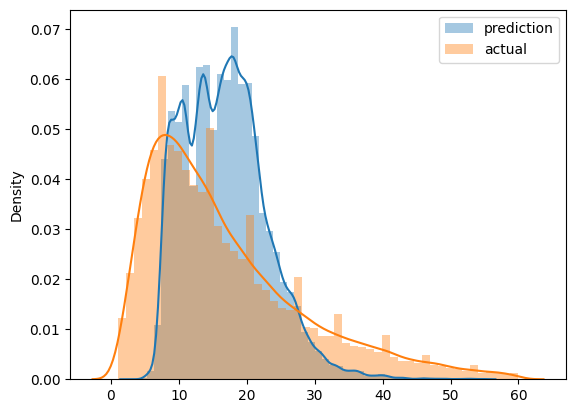

In [15]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [16]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [17]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [18]:
len(df_train), len(df_val)

(73908, 61921)

In [19]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [20]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715205596356

In [23]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [24]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


11.167275941179728

In [25]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "J")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val) 
    rsme = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rsme', rsme)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.96598                           
[1]	validation-rmse:6.62853                           
[2]	validation-rmse:6.58566                           
[3]	validation-rmse:6.57291                           
[4]	validation-rmse:6.56401                           
[5]	validation-rmse:6.55534                           
[6]	validation-rmse:6.54772                           
[7]	validation-rmse:6.53758                           
[8]	validation-rmse:6.53409                           
[9]	validation-rmse:6.52700                           
[10]	validation-rmse:6.51819                          
[11]	validation-rmse:6.50762                          
[12]	validation-rmse:6.50473                          
[13]	validation-rmse:6.49867                          
[14]	validation-rmse:6.49306                          
[15]	validation-rmse:6.48681                          
[16]	validation-rmse:6.48277                          
[17]	validation-rmse:6.47382                          
[18]	valid

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.50280                                                   
[1]	validation-rmse:10.87489                                                   
[2]	validation-rmse:10.32099                                                   
[3]	validation-rmse:9.83047                                                    
[4]	validation-rmse:9.40362                                                    
[5]	validation-rmse:9.03076                                                    
[6]	validation-rmse:8.69988                                                    
[7]	validation-rmse:8.42168                                                    
[8]	validation-rmse:8.17436                                                    
[9]	validation-rmse:7.96012                                                    
[10]	validation-rmse:7.77280                                                   
[11]	validation-rmse:7.61390                                                   
[12]	validation-rmse:7.47796            

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.57782                                                   
[1]	validation-rmse:11.00751                                                   
[2]	validation-rmse:10.49893                                                   
[3]	validation-rmse:10.04303                                                   
[4]	validation-rmse:9.63873                                                    
[5]	validation-rmse:9.27805                                                    
[6]	validation-rmse:8.95945                                                    
[7]	validation-rmse:8.67278                                                    
[8]	validation-rmse:8.42242                                                    
[9]	validation-rmse:8.19940                                                    
[10]	validation-rmse:8.00241                                                   
[11]	validation-rmse:7.83288                                                   
[12]	validation-rmse:7.68163            

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.52972                                                      
[1]	validation-rmse:6.72120                                                      
[2]	validation-rmse:6.56553                                                      
[3]	validation-rmse:6.52601                                                      
[4]	validation-rmse:6.50542                                                      
[5]	validation-rmse:6.48828                                                      
[6]	validation-rmse:6.47979                                                      
[7]	validation-rmse:6.47126                                                      
[8]	validation-rmse:6.46508                                                      
[9]	validation-rmse:6.45888                                                      
[10]	validation-rmse:6.45634                                                     
[11]	validation-rmse:6.45312                                                     
[12]	validation-

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:41:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.55793                                                    
[4]	validation-rmse:8.10403                                                    
[5]	validation-rmse:7.76399                                                    
[6]	validation-rmse:7.50776                                                    
[7]	validation-rmse:7.31556                                                    
[8]	validation-rmse:7.17338                                                    
[9]	validation-rmse:7.06418                                                    
[10]	validation-rmse:6.98245                                                   
[11]	validation-rmse:6.91957                                                   
[12]	validation-rmse:6.87387                                                   
[13]	validation-rmse:6.83841                                                   
[14]	validation-rmse:6.80963                                                   
[15]	validation-rmse:6.78673            

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:42:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67483                                                    
[1]	validation-rmse:7.30449                                                    
[2]	validation-rmse:6.81131                                                    
[3]	validation-rmse:6.62496                                                    
[4]	validation-rmse:6.54830                                                    
[5]	validation-rmse:6.51048                                                    
[6]	validation-rmse:6.49122                                                    
[7]	validation-rmse:6.47747                                                    
[8]	validation-rmse:6.46782                                                    
[9]	validation-rmse:6.46055                                                    
[10]	validation-rmse:6.45592                                                   
[11]	validation-rmse:6.44886                                                   
[12]	validation-rmse:6.44457            

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.37293                                                  
[1]	validation-rmse:6.79503                                                  
[2]	validation-rmse:6.69280                                                  
[3]	validation-rmse:6.66480                                                  
[4]	validation-rmse:6.65431                                                  
[5]	validation-rmse:6.64632                                                  
[6]	validation-rmse:6.63871                                                  
[7]	validation-rmse:6.63168                                                  
[8]	validation-rmse:6.62593                                                  
[9]	validation-rmse:6.62480                                                  
[10]	validation-rmse:6.62075                                                 
[11]	validation-rmse:6.61828                                                 
[12]	validation-rmse:6.61426                                    

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.51004                                                  
[1]	validation-rmse:8.07041                                                  
[2]	validation-rmse:7.32066                                                  
[3]	validation-rmse:6.96516                                                  
[4]	validation-rmse:6.79029                                                  
[5]	validation-rmse:6.68008                                                  
[6]	validation-rmse:6.62211                                                  
[7]	validation-rmse:6.58988                                                  
[8]	validation-rmse:6.57035                                                  
[9]	validation-rmse:6.55893                                                  
[10]	validation-rmse:6.54642                                                 
[11]	validation-rmse:6.54062                                                 
[12]	validation-rmse:6.53476                                    

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:43:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.75428                                                  
[4]	validation-rmse:6.75125                                                  
[5]	validation-rmse:6.74642                                                  
[6]	validation-rmse:6.74097                                                  
[7]	validation-rmse:6.73344                                                  
[8]	validation-rmse:6.73257                                                  
[9]	validation-rmse:6.72850                                                  
[10]	validation-rmse:6.72452                                                 
[11]	validation-rmse:6.72238                                                 
[12]	validation-rmse:6.71706                                                 
[13]	validation-rmse:6.71648                                                 
[14]	validation-rmse:6.71571                                                 
[15]	validation-rmse:6.71404                                    

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:8.53707                                                  
[8]	validation-rmse:8.29933                                                  
[9]	validation-rmse:8.09385                                                  
[10]	validation-rmse:7.91653                                                 
[11]	validation-rmse:7.76216                                                 
[12]	validation-rmse:7.63062                                                 
[13]	validation-rmse:7.51610                                                 
[14]	validation-rmse:7.41818                                                 
[15]	validation-rmse:7.33371                                                 
[16]	validation-rmse:7.26117                                                 
[17]	validation-rmse:7.19849                                                 
[18]	validation-rmse:7.14428                                                 
[19]	validation-rmse:7.09672                                    

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.03728                                                  
[1]	validation-rmse:10.08320                                                  
[2]	validation-rmse:9.31779                                                   
[3]	validation-rmse:8.70727                                                   
[4]	validation-rmse:8.22423                                                   
[5]	validation-rmse:7.84280                                                   
[6]	validation-rmse:7.54930                                                   
[7]	validation-rmse:7.32107                                                   
[8]	validation-rmse:7.14160                                                   
[9]	validation-rmse:7.00340                                                   
[10]	validation-rmse:6.89215                                                  
[11]	validation-rmse:6.80637                                                  
[12]	validation-rmse:6.74031                        

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.67753                                                    
[1]	validation-rmse:9.53827                                                     
[2]	validation-rmse:8.70534                                                     
[3]	validation-rmse:8.10746                                                     
[4]	validation-rmse:7.68203                                                     
[5]	validation-rmse:7.38471                                                     
[6]	validation-rmse:7.17537                                                     
[7]	validation-rmse:7.02655                                                     
[8]	validation-rmse:6.92282                                                     
[9]	validation-rmse:6.84706                                                     
[10]	validation-rmse:6.79207                                                    
[11]	validation-rmse:6.75319                                                    
[12]	validation-rmse:6.72277

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.19205                                                    
[1]	validation-rmse:8.87384                                                     
[2]	validation-rmse:8.03739                                                     
[3]	validation-rmse:7.51964                                                     
[4]	validation-rmse:7.20143                                                     
[5]	validation-rmse:7.00785                                                     
[6]	validation-rmse:6.88458                                                     
[7]	validation-rmse:6.80816                                                     
[8]	validation-rmse:6.75326                                                     
[9]	validation-rmse:6.72110                                                     
[10]	validation-rmse:6.69850                                                    
[11]	validation-rmse:6.68418                                                    
[12]	validation-rmse:6.67108

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.97851                                                     
[1]	validation-rmse:8.59027                                                     
[2]	validation-rmse:7.75425                                                     
[3]	validation-rmse:7.26576                                                     
[4]	validation-rmse:6.98129                                                     
[5]	validation-rmse:6.81444                                                     
[6]	validation-rmse:6.71545                                                     
[7]	validation-rmse:6.65274                                                     
[8]	validation-rmse:6.61137                                                     
[9]	validation-rmse:6.58217                                                     
[10]	validation-rmse:6.56471                                                    
[11]	validation-rmse:6.55180                                                    
[12]	validation-rmse:6.54019

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:46:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.75615                                                     
[4]	validation-rmse:8.29823                                                     
[5]	validation-rmse:7.94199                                                     
[6]	validation-rmse:7.66761                                                     
[7]	validation-rmse:7.45798                                                     
[8]	validation-rmse:7.29578                                                     
[9]	validation-rmse:7.17148                                                     
[10]	validation-rmse:7.07649                                                    
[11]	validation-rmse:7.00227                                                    
[12]	validation-rmse:6.94538                                                    
[13]	validation-rmse:6.90096                                                    
[14]	validation-rmse:6.86546                                                    
[15]	validation-rmse:6.83760

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:6.75029                                                     
[6]	validation-rmse:6.74327                                                     
[7]	validation-rmse:6.73582                                                     
[8]	validation-rmse:6.73132                                                     
[9]	validation-rmse:6.72655                                                     
[10]	validation-rmse:6.72094                                                    
[11]	validation-rmse:6.71776                                                    
[12]	validation-rmse:6.71540                                                    
[13]	validation-rmse:6.71347                                                    
[14]	validation-rmse:6.71105                                                    
[15]	validation-rmse:6.70725                                                    
[16]	validation-rmse:6.70241                                                    
[17]	validation-rmse:6.69797

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.52979                                                     
[2]	validation-rmse:8.70082                                                     
[3]	validation-rmse:8.10827                                                     
[4]	validation-rmse:7.68812                                                     
[5]	validation-rmse:7.39450                                                     
[6]	validation-rmse:7.18740                                                     
[7]	validation-rmse:7.04364                                                     
[8]	validation-rmse:6.94322                                                     
[9]	validation-rmse:6.87095                                                     
[10]	validation-rmse:6.81639                                                    
[11]	validation-rmse:6.77777                                                    
[12]	validation-rmse:6.74924                                                    
[13]	validation-rmse:6.72808

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:47:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.09868                                                    
[1]	validation-rmse:10.18927                                                    
[2]	validation-rmse:9.45398                                                     
[3]	validation-rmse:8.86346                                                     
[4]	validation-rmse:8.39278                                                     
[5]	validation-rmse:8.02151                                                     
[6]	validation-rmse:7.72889                                                     
[7]	validation-rmse:7.49915                                                     
[8]	validation-rmse:7.31918                                                     
[9]	validation-rmse:7.17847                                                     
[10]	validation-rmse:7.06709                                                    
[11]	validation-rmse:6.97872                                                    
[12]	validation-rmse:6.90961

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:48:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.65492                                                    
[1]	validation-rmse:9.50117                                                     
[2]	validation-rmse:8.66220                                                     
[3]	validation-rmse:8.06218                                                     
[4]	validation-rmse:7.62846                                                     
[5]	validation-rmse:7.33504                                                     
[6]	validation-rmse:7.12425                                                     
[7]	validation-rmse:6.96677                                                     
[8]	validation-rmse:6.86250                                                     
[9]	validation-rmse:6.78967                                                     
[10]	validation-rmse:6.73372                                                    
[11]	validation-rmse:6.68337                                                    
[12]	validation-rmse:6.65536

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:49:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.42956                                                    
[1]	validation-rmse:9.18730                                                     
[2]	validation-rmse:8.34448                                                     
[3]	validation-rmse:7.78452                                                     
[4]	validation-rmse:7.41530                                                     
[5]	validation-rmse:7.17444                                                     
[6]	validation-rmse:7.01729                                                     
[7]	validation-rmse:6.91426                                                     
[8]	validation-rmse:6.83991                                                     
[9]	validation-rmse:6.79035                                                     
[10]	validation-rmse:6.75525                                                    
[11]	validation-rmse:6.73005                                                    
[12]	validation-rmse:6.71015

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:50:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.60994                                                     
[1]	validation-rmse:7.23913                                                     
[2]	validation-rmse:6.76388                                                     
[3]	validation-rmse:6.59068                                                     
[4]	validation-rmse:6.51477                                                     
[5]	validation-rmse:6.48077                                                     
[6]	validation-rmse:6.45529                                                     
[7]	validation-rmse:6.44716                                                     
[8]	validation-rmse:6.43883                                                     
[9]	validation-rmse:6.43606                                                     
[10]	validation-rmse:6.43125                                                    
[11]	validation-rmse:6.42721                                                    
[12]	validation-rmse:6.42377

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.75033                                                    
[1]	validation-rmse:11.32066                                                    
[2]	validation-rmse:10.92287                                                    
[3]	validation-rmse:10.55466                                                    
[4]	validation-rmse:10.21447                                                    
[5]	validation-rmse:9.89999                                                     
[6]	validation-rmse:9.61007                                                     
[7]	validation-rmse:9.34323                                                     
[8]	validation-rmse:9.09710                                                     
[9]	validation-rmse:8.87213                                                     
[10]	validation-rmse:8.66341                                                    
[11]	validation-rmse:8.47257                                                    
[12]	validation-rmse:8.29903

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79411                                                    
[1]	validation-rmse:11.40246                                                    
[2]	validation-rmse:11.03643                                                    
[3]	validation-rmse:10.69508                                                    
[4]	validation-rmse:10.37727                                                    
[5]	validation-rmse:10.08104                                                    
[6]	validation-rmse:9.80553                                                     
[7]	validation-rmse:9.55048                                                     
[8]	validation-rmse:9.31267                                                     
[9]	validation-rmse:9.09179                                                     
[10]	validation-rmse:8.88698                                                    
[11]	validation-rmse:8.69763                                                    
[12]	validation-rmse:8.52344

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77399                                                    
[1]	validation-rmse:11.36478                                                    
[2]	validation-rmse:10.98424                                                    
[3]	validation-rmse:10.63090                                                    
[4]	validation-rmse:10.30211                                                    
[5]	validation-rmse:9.99740                                                     
[6]	validation-rmse:9.71527                                                     
[7]	validation-rmse:9.45411                                                     
[8]	validation-rmse:9.21238                                                     
[9]	validation-rmse:8.98860                                                     
[10]	validation-rmse:8.78290                                                    
[11]	validation-rmse:8.59226                                                    
[12]	validation-rmse:8.41779

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:58:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.26211                                                     
[1]	validation-rmse:10.45339                                                     
[2]	validation-rmse:9.76996                                                      
[3]	validation-rmse:9.19652                                                      
[4]	validation-rmse:8.71546                                                      
[5]	validation-rmse:8.31808                                                      
[6]	validation-rmse:7.98558                                                      
[7]	validation-rmse:7.71302                                                      
[8]	validation-rmse:7.48861                                                      
[9]	validation-rmse:7.30423                                                      
[10]	validation-rmse:7.15389                                                     
[11]	validation-rmse:7.03024                                                     
[12]	validation-

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:59:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69707                                                     
[1]	validation-rmse:11.22273                                                     
[2]	validation-rmse:10.78757                                                     
[3]	validation-rmse:10.38888                                                     
[4]	validation-rmse:10.02498                                                     
[5]	validation-rmse:9.69195                                                      
[6]	validation-rmse:9.38843                                                      
[7]	validation-rmse:9.11109                                                      
[8]	validation-rmse:8.85833                                                      
[9]	validation-rmse:8.63046                                                      
[10]	validation-rmse:8.42187                                                     
[11]	validation-rmse:8.23291                                                     
[12]	validation-

KeyboardInterrupt: 

In [25]:

params = {
    'learning_rate' : 0.14617073692396848, 
    'max_depth': 57,
    'min_child_weight': 1.0543003960973405,
    'objective': 'reg:linear',
    'reg_alpha': 0.05008428417954409,
    'reg_lambda': 0.010143480198486687,
    'seed': 42}

mlflow.xgboost.autolog(disable=True)

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2024/05/24 16:16:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7ce17c5f0956488ba140174fb92b772b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:16:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.03728
[1]	validation-rmse:10.08320
[2]	validation-rmse:9.31779
[3]	validation-rmse:8.70727
[4]	validation-rmse:8.22423
[5]	validation-rmse:7.84280
[6]	validation-rmse:7.54930
[7]	validation-rmse:7.32107
[8]	validation-rmse:7.14160
[9]	validation-rmse:7.00340
[10]	validation-rmse:6.89215
[11]	validation-rmse:6.80637
[12]	validation-rmse:6.74031
[13]	validation-rmse:6.68849
[14]	validation-rmse:6.64535
[15]	validation-rmse:6.61234
[16]	validation-rmse:6.58376
[17]	validation-rmse:6.56171
[18]	validation-rmse:6.54239
[19]	validation-rmse:6.52566
[20]	validation-rmse:6.51313
[21]	validation-rmse:6.50205
[22]	validation-rmse:6.49305
[23]	validation-rmse:6.48523
[24]	validation-rmse:6.47829
[25]	validation-rmse:6.47201
[26]	validation-rmse:6.46686
[27]	validation-rmse:6.46178
[28]	validation-rmse:6.45759
[29]	validation-rmse:6.45443
[30]	validation-rmse:6.45128
[31]	validation-rmse:6.44885
[32]	validation-rmse:6.44705
[33]	validation-rmse:6.44555
[34]	validation-rmse:6

2024/05/24 16:18:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:18:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/05/24 16:18:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the tradit

In [21]:
with mlflow.start_run():
    params = {
    'learning_rate' : 0.14617073692396848, 
    'max_depth': 57,
    'min_child_weight': 1.0543003960973405,
    'objective': 'reg:linear',
    'reg_alpha': 0.05008428417954409,
    'reg_lambda': 0.010143480198486687,
    'seed': 42}
    
    mlflow.log_params(params)

    
    mlflow.xgboost.autolog(disable=True)

    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)


    booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
            )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path = "preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [18:03:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.03728
[1]	validation-rmse:10.08320
[2]	validation-rmse:9.31779
[3]	validation-rmse:8.70727
[4]	validation-rmse:8.22423
[5]	validation-rmse:7.84280
[6]	validation-rmse:7.54930
[7]	validation-rmse:7.32107
[8]	validation-rmse:7.14160
[9]	validation-rmse:7.00340
[10]	validation-rmse:6.89215
[11]	validation-rmse:6.80637
[12]	validation-rmse:6.74031
[13]	validation-rmse:6.68849
[14]	validation-rmse:6.64535
[15]	validation-rmse:6.61234
[16]	validation-rmse:6.58376
[17]	validation-rmse:6.56171
[18]	validation-rmse:6.54239
[19]	validation-rmse:6.52566
[20]	validation-rmse:6.51313
[21]	validation-rmse:6.50205
[22]	validation-rmse:6.49305
[23]	validation-rmse:6.48523
[24]	validation-rmse:6.47829
[25]	validation-rmse:6.47201
[26]	validation-rmse:6.46686
[27]	validation-rmse:6.46178
[28]	validation-rmse:6.45759
[29]	validation-rmse:6.45443
[30]	validation-rmse:6.45128
[31]	validation-rmse:6.44885
[32]	validation-rmse:6.44705
[33]	validation-rmse:6.44555
[34]	validation-rmse:6

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [18:04:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [25]:
import mlflow
logged_model = 'runs:/a659b685bcb64c08be9d0af6fc9020ce/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
 

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [18:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [26]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: a659b685bcb64c08be9d0af6fc9020ce

In [27]:
xgboost_model = mlflow.xgboost.load_model(model_uri=logged_model)

c:\Users\crab\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [18:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [28]:
xgboost_model

In [31]:
y_pred = xgboost_model.predict(valid)

In [32]:
y_pred [:10]

array([14.212163 ,  7.0482526, 14.264443 , 24.46753  ,  9.496451 ,
       17.1498   , 10.447105 ,  8.409666 ,  9.762197 , 17.557404 ],
      dtype=float32)

In [28]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog(log_datasets = False)

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\crab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The defau